# Discretization

We use the Rouwenhorst method to approximate a continuous Markov process with a finite-state Markov chain. In this notebook, we discretize an AR(1) in logs with persistence $\rho$: 
\begin{align}
\log y_t = \rho \log y_{t-1} + \epsilon_{t},
\end{align}
where $\epsilon_{t}$ is drawn from a normal with zero mean and variance $\sigma^2$. 

#### Load packages

In [1]:
cd(@__DIR__) # change directory to the folder where the file lives
using Pkg
Pkg.activate(".")

using Parameters
using Plots
pyplot()
default(linewidth=1)

using Distributions
using LaTeXStrings

 Activating environment at `c:\Users\SWOEHRM\Google Drive\PhD\Codes Lab\HANK\7DayCourse\Project.toml`


## Rouwenhorst method

See slides of Advance Macro I. 

In [2]:
function Rouwenhorst_AR1(ρ, σ2, N)

    p= (1+ρ)/2
    q= (1+ρ)/2
    
    # Construct Markov Chain recursively
    if N ==2
        tm= [p 1-p; 1-q q]
    elseif N>2
        tm= [p 1-p; 1-q q]
        for i in 2:N-1
            tm= p .* hcat( vcat(tm, zeros(1,i)), zeros(i+1,1) ) + 
            (1-p) .* hcat( zeros(i+1,1), vcat(tm, zeros(1,i)) ) +
            (1-q) .* hcat( vcat(zeros(1,i), tm), zeros(i+1,1) ) +
                q .* hcat( zeros(i+1,1), vcat(zeros(1,i), tm) )
            
            tm[2:end-1,:]= tm[2:end-1,:]./2 # divide all but the first and last row by two
        end
    else
        println("The number of grid points needs to be larger than two")
    end
    
    # Create state vector - here M is basically sqrt(iN-1)
    ψ= sqrt((σ2 / (1 - ρ^2))) * sqrt(N - 1)
    state= LinRange(-ψ, ψ, N)

    return state, tm

end # end Rouwenhorst_AR1 function

Rouwenhorst_AR1 (generic function with 1 method)

#### Helper functions

In [3]:
function MarkovChain(state,tm,N,T)

    istate= zeros(Int,T)
    simstate= zeros(T)

    mcdf= cumsum(tm,dims=2)
    mcdf= [zeros(N) mcdf] # add a zero column
    r= rand(Uniform(0,1),(T))


    # Initialize 
    istate[1]= (N÷2)+1
    simstate[1]= state[(N÷2)+1] # if N uneven, that gets the middle, i.e. zero
   

    for t in 1:T-1
        
        istate[t+1]= findall(<(r[t]),mcdf[istate[t],:])[end]
        simstate[t+1]= state[istate[t+1]]

    end

    return simstate, istate

end


function SimulateAR1(ρ, σ, T)

    shock= rand(Normal(0.0,σ2),(T))
    AR1= zeros(T)
    for t in 1:T-1
        AR1[t+1]= ρ * AR1[t] + shock[t]
    end

    return AR1

end

SimulateAR1 (generic function with 1 method)

## Illustration

Discretize the process for different persistence parameters $\rho$. Rouwenhorst’s method still works well for processes with high persistence. 

In [4]:
N=3; # states
T= 100000; # Simulation of Markov Chain

# Discretization I
ρ= 0.9;
σ2= (1-ρ^2); # solved such that σ2 of proces = 1
stateR9, tmR9= Rouwenhorst_AR1(ρ,σ2,N);
AR1_9= SimulateAR1(ρ, sqrt(σ2), T); # Continuous

# Discretization II
ρ= 0.99;
σ2= (1-ρ^2); # solved such that σ2 of proces = 1
stateR99, tmR99= Rouwenhorst_AR1(ρ,σ2,N);
AR1_99= SimulateAR1(ρ, sqrt(σ2), T); # Continuous

# Discretization III
ρ= 0.999;
σ2= (1-ρ^2); # solved such that σ2 of proces = 1
stateR999, tmR999= Rouwenhorst_AR1(ρ,σ2,N);
AR1_999= SimulateAR1(ρ, sqrt(σ2), T); # Continuous

# Simulation
simstateR9, istateR9= MarkovChain(stateR9,tmR9,N,T);
simstateR99, istateR99= MarkovChain(stateR99,tmR99,N,T);
simstateR999, istateR999= MarkovChain(stateR999,tmR999,N,T);


### Plot comparison

Rouwenhorst's method works very well for stochastic processes with high persistence. The following plots illustrates this. For instance, Tauchen's method would be a straight line at zero for $\rho = 0.99$. 

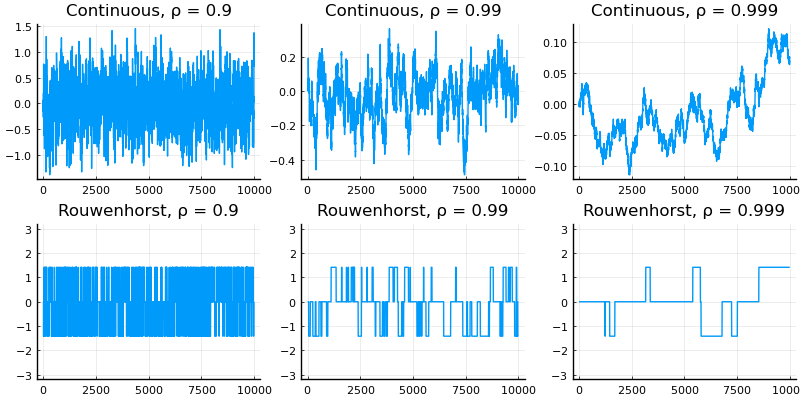

In [5]:
x= 1:10000
M= 3.0
p1= plot(x, AR1_9[x], title = "Continuous, ρ = 0.9", titlefontsize= 12)
p2= plot(x, AR1_99[x], title = "Continuous, ρ = 0.99", titlefontsize= 12)
p3= plot(x, AR1_999[x], title = "Continuous, ρ = 0.999", titlefontsize= 12)
p4= plot(x, simstateR9[x], ylim=[-M,M], title = "Rouwenhorst, ρ = 0.9", titlefontsize= 12)
p5= plot(x, simstateR99[x], ylim=[-M,M], title = "Rouwenhorst, ρ = 0.99", titlefontsize= 12)
p6= plot(x, simstateR999[x], ylim=[-M,M], title = "Rouwenhorst, ρ = 0.999", titlefontsize= 12)
plot(p1, p2, p3, p4, p5, p6, layout = (2, 3), legend = false)
plot!(size=(800,400))


In the following notebooks, we use this method to discretize the stochastic income process of households. In an incomplete markets economy, we posit that the idiosyncratic income $y$ of agents follows an AR(1) in logs. 
To illustrate, let's look at the transition matrix and the state induced by the stochastic process. Since the process is in logs, the income of an agent is $exp(y)$. 

In [6]:
display(exp.(stateR9))
display(tmR9)

3-element Array{Float64,1}:
 0.2431167344342142
 1.0
 4.1132503787829275

3×3 Array{Float64,2}:
 0.9025  0.095  0.0025
 0.0475  0.905  0.0475
 0.0025  0.095  0.9025

The first state has income $0.243$, the second one $1.0$, and the third $4.113$.

The transition matrix gives the transition probabilities into the different states. For instance, if an agent is of type 1, she sits in the first row. In the next period, she will stay type 1 with probability $0.9025$, she will transition to type 2 with probability $0.095$, and she will transition to type 3 with probability $0.0025$. 

When we encounter an expectation operator in the following notebooks, it will be taken over realization of idiosyncratic income shocks, who follow a Markov process discretized as above.  